In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
import spacy
import plotly.express as px

from keybert import KeyBERT
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

/Users/jeon-yewon/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv('BA_AirlineReviews.csv')

In [3]:
df.head()

,Unnamed: 0,OverallRating,ReviewHeader,Name,Datetime,VerifiedReview,ReviewBody,TypeOfTraveller,SeatType,Route,DateFlown,SeatComfort,CabinStaffService,GroundService,ValueForMoney,Recommended,Aircraft,Food&Beverages,InflightEntertainment,Wifi&Connectivity
0,0,1.0,"""Service level far worse then Ryanair""",L Keele,19th November 2023,True,4 Hours before takeoff we received a Mail stat...,Couple Leisure,Economy Class,London to Stuttgart,November 2023,1.0,1.0,1.0,1.0,no,NaN,NaN,NaN,NaN
1,1,3.0,"""do not upgrade members based on status""",Austin Jones,19th November 2023,True,I recently had a delay on British Airways from...,Business,Economy Class,Brussels to London,November 2023,2.0,3.0,1.0,2.0,no,A320,1.0,2.0,2.0
2,2,8.0,"""Flight was smooth and quick""",M A Collie,16th November 2023,False,"Boarded on time, but it took ages to get to th...",Couple Leisure,Business Class,London Heathrow to Dublin,November 2023,3.0,3.0,4.0,3.0,yes,A320,4.0,NaN,NaN
3,3,1.0,"""Absolutely hopeless airline""",Nigel Dean,16th November 2023,True,"5 days before the flight, we were advised by B...",Couple Leisure,Economy Class,London to Dublin,December 2022,3.0,3.0,1.0,1.0,no,NaN,NaN,NaN,NaN
4,4,1.0,"""Customer Service is non existent""",Gaylynne Simpson,14th November 2023,False,"We traveled to Lisbon for our dream vacation, ...",Couple Leisure,Economy Class,London to Lisbon,November 2023,1.0,1.0,1.0,1.0,no,NaN,1.0,1.0,1.0


In [4]:
df.columns

Index(['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime',
       'VerifiedReview', 'ReviewBody', 'TypeOfTraveller', 'SeatType', 'Route',
       'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService',
       'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages',
       'InflightEntertainment', 'Wifi&Connectivity'],
      dtype='object')

In [5]:
df = df.drop(columns=['Unnamed: 0', 'OverallRating', 'ReviewHeader', 'Name', 'Datetime',
       'VerifiedReview', 'TypeOfTraveller', 'SeatType', 'Route',
       'DateFlown', 'SeatComfort', 'CabinStaffService', 'GroundService',
       'ValueForMoney', 'Recommended', 'Aircraft', 'Food&Beverages',
       'InflightEntertainment', 'Wifi&Connectivity'])
df.head()

,ReviewBody
0,4 Hours before takeoff we received a Mail stat...
1,I recently had a delay on British Airways from...
2,"Boarded on time, but it took ages to get to th..."
3,"5 days before the flight, we were advised by B..."
4,"We traveled to Lisbon for our dream vacation, ..."


In [6]:
df['token_count'] = df['ReviewBody'].str.split().apply(len)
df['short_paragraph'] = df['ReviewBody'].apply(func=lambda x: ' '.join(x.split()[:20]))
df = df[df['token_count'] > 5]
df.head()

,ReviewBody,token_count,short_paragraph
0,4 Hours before takeoff we received a Mail stat...,125,4 Hours before takeoff we received a Mail stat...
1,I recently had a delay on British Airways from...,206,I recently had a delay on British Airways from...
2,"Boarded on time, but it took ages to get to th...",54,"Boarded on time, but it took ages to get to th..."
3,"5 days before the flight, we were advised by B...",255,"5 days before the flight, we were advised by B..."
4,"We traveled to Lisbon for our dream vacation, ...",172,"We traveled to Lisbon for our dream vacation, ..."


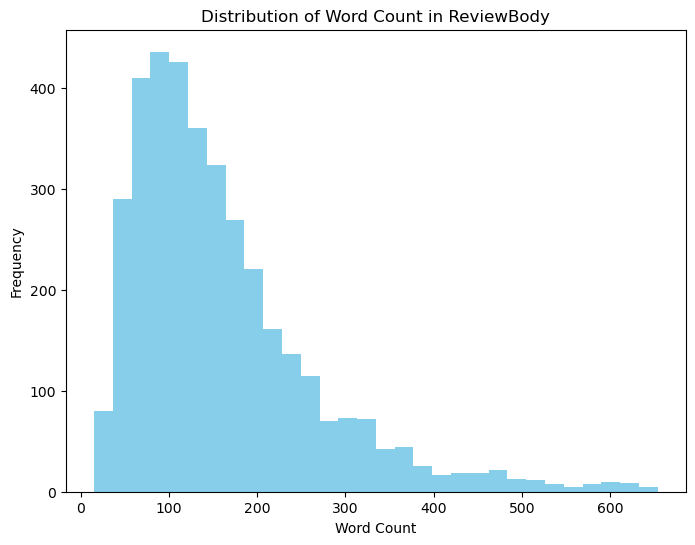

In [7]:
plt.figure(figsize=(8, 6))
plt.hist(df['token_count'], bins=30, color='skyblue')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Word Count in ReviewBody')
plt.show()

In [8]:
from arrow import now

COLUMN = 'ReviewBody' # 컬럼 이름
MIN_DF = 2 # 최소 빈도
MODEL = 'all-MiniLM-L6-v2' # 모델 이름
STOP_WORDS = 'english'

In [ ]:
# model_start = now() # 현재 시간 ---> 실행 o
model = KeyBERT(model=MODEL) # 해당 모델 이름으로 가져온다  ===> 실행 x

model.max_seq_length = 512 # 모델의 최대 길이 설정

In [ ]:
raw_documents = df[COLUMN].values # ReviewBody 열 값
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words=STOP_WORDS, min_df=MIN_DF,)
document_embeddings, word_embeddings = model.extract_embedding(docs=raw_documents, vectorizer=vectorizer) # 문서와 단어 임베딩 추출

print('embedding time : ', now() - model_start) # 시간
print('document : ', len(documents_embeddings)) # 문서 임베딩 개수, 3701
print('words : ', len(word_embeddings)) # 단어 임베딩 개수, 37672

In [ ]:
# 각 문서에서 키워드를 추출한다. top_n = 1(가장 중요한 단어)
keywords = model.extract_keywords(docs=raw_documents, top_n=1, stop_words=STOP_WORDS, vectorizer=vectorizer,
                                  doc_embedding=document_mebeddings, word_embeddings=word_embeddings, min_df=MIN_DF)

df['keyword/weight'] = keywords # 가중치 저장
df['keyword'] = df['keyword/weight'].apply(func=lambda x: x[0][0] if len(x) else '') # 키워드 저장

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_componets=2, random_state=42) # n_componets : 2D
document_embeddings_tsne = tsne_model.fit_transform(document_embeddings) # 문서 임베딩을 tsne 통해 변환

df_tsne = df.copy() # 데이터 프레임 복사
df.tsne['tsne_component_1'] = document_embeddings_tsne[:, 0] # x축
df_tsne['tsne_component_2'] = document_embeddings_tsne[:, 1] # y축 # -> 하나씩 대입

fig = px.scatter(df_tsne, x='tsne_component_1', y='tsne_component_2', color='token_count',
                 hover_data=['short paragraph', 'ReviewBody', 'token count', 'keyword'], # 마우스를 올렸을 때 보여줄 정보
                 labels={'tsne_component_1':'TSNE Component 1', 'tsne_component_2' : 'TSNE Component 2'},
                 title='Visualization of Document Embeddings', color_continuous_scale='virdis')

fig.show()

In [ ]:
print(df['keyword'].value_counts().head(n=40).index.tolist())

In [ ]:
top_keywords = [item for item in df['keyword'].value_counts().head(n=40).index.tolist() if len(item)]
filtered_df = df[df['keyword'].isin(top_keywords)]

keywords_counts = filtered_df['keyword'].value_counts().reset_index()
keywords_counts.columns = ['keyword', 'count']

fig = px.bar(keyword_counts, x='count', y='keyword', color='keyword', title='Top Keywords Bar Chart', orientation='h')

fig.update_layout(xaxis_title='Count', yaxis_title='Keyword', height=800, width=900)
fig.show()

## WordCloud

In [ ]:
# word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = ' '.join(df['short paragraph'])

wordcloud = WordCloud(width=600, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Short Paragraph')
plt.show()

## 데이터 전처리, 감정분석

In [ ]:
df['tokenized_text'] = df['ReviewBody'].apply(lambda x: word_tokenize(x.lower()))

nlp = spacy.load('en_core_web_sm')

In [ ]:
def lemmatize_with_spacy(text):
    doc = nlp(text)
    lemmatized_text = [token.lemma_ for token in doc]
    return lemmatized_text

In [ ]:
df['tokenized_text'] = df['RevieBody'].apply(lambda x: [token.text for token in nlp(x.lower())])
df['clean_text'] = df['ReviewBody'].apply(lambda x: lemmatize_with_spacy(x.lower()))

In [ ]:
df.head()

In [ ]:
sentences_df = pd.DataFrame(df)
max_token_limit = 160

sentences_df['clean'] = sentences_df['RevviewBody'].apply(lambda x: ' '.join(x.split()[:max_token_limit]) if len(x.split()) 
                                                          > max_token_limit else x)

sentences_df.head()

In [ ]:
from plotly.express import line_polar

def plot(input_df, column, model):
    # pipeline은 hagging face transformers 라이브러리에서 제공하는 기능 
    # => 지정된 작업 'sentiment-analysis', 모델을 기반으로
    # 감정 분석 파이프라인을 생성한다.
    pipe = pipeline(task='sentiment-analysis', model=model)
    result_df = pd.DataFrame(pipe(input_df[column].values.tolist())).groupby(by='label').sum().reset_index()

    fig = line_polar(data_frame=result_df, r='score', theta='label', line_close=True, title='Airline Sentiment', log_r=True)
    fig.show()

In [ ]:
models = [
    'bhadresh-savani/distilbert-base-uncased-emotion',
    'cardiffnlp/twitter-roberta-base-sentiment',
    'nlptown/bert-base-multilingual-uncased-sentiment',
] # 감정분석 모델 

for model in models:
    plot(sentences_df, 'clean', model)